<a href="https://colab.research.google.com/github/PGM-Lab/probai-2021-pyro/blob/main/Day3/notebooks/FA_binomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade pyro-ppl torch==1.8.1 

import pyro
import torch
import matplotlib
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms

     |████████████████████████████████| 634kB 7.1MB/s 


## Get the MNIST data

In [2]:
data = datasets.MNIST('./data', train=True, download=True)

# We only select the digits 0, 1, and 2 and only the first 100 of each of these
# digits

selector = np.array([], dtype=int)
for i in [5, 6, 7]:
    selector = np.concatenate((selector, np.where(data.targets == i)[0][:100]))
data.data = data.data[selector, :, :]
data.targets = data.targets[selector]

# Binarize the data
data.data[data.data<128] = 0
data.data[data.data>=128] = 1

data.data = data.data.type(torch.float)
data.data = data.data.reshape(300,-1)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


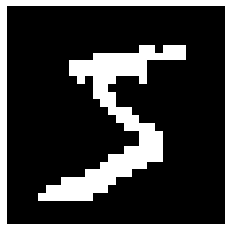

In [3]:
def display_image(x):
    plt.axis('off')
    plt.imshow(x.reshape((28, 28)), cmap="gray")

toy_image = data.data[0,:]
display_image(toy_image)

## The model

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day3/Figures/FA_model.png?raw=1" width=300/>

In [4]:
def model(data, no_attributes, no_latent):

    w = pyro.sample("w", dist.Normal(torch.zeros(no_attributes, no_latent)*0., 1.).to_event(2))
    with pyro.plate('local', len(data)):
        z = pyro.sample("z", dist.Normal(torch.zeros(no_latent, dtype=torch.float), 1.).to_event(1))
        x = pyro.sample("x", dist.Binomial(logits = torch.mm(z, torch.t(w))).to_event(1), obs=data)

    return x

## The guide

In [5]:
def guide(data, no_attributes, no_latent):

    z_loc = pyro.param("z_loc", torch.zeros((len(data), no_latent), dtype=torch.float))
    z_scale = pyro.param("z_scale", torch.ones((len(data), no_latent), dtype=torch.float),
                         constraint=constraints.positive)
    with pyro.plate('local', len(data)):
        pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

    w_loc = pyro.param("w_loc", torch.zeros(no_attributes, no_latent, dtype=torch.float))
    w_scale = pyro.param("w_scale", torch.ones(no_attributes, no_latent, dtype=torch.float), constraint=constraints.positive)

    pyro.sample("w", dist.Normal(w_loc, w_scale).to_event(2))

## Perform learning

In [6]:
def train(svi, data, no_attr, no_latent):
    # initialize loss accumulator

    epoch_loss = svi.step(data, no_attr, no_latent)

    # return epoch loss
    normalizer_train = len(data)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

[epoch 000] average training loss: 204537.0312
[epoch 100] average training loss: 61527.1903
[epoch 200] average training loss: 56005.2148
[epoch 300] average training loss: 55438.8947
[epoch 400] average training loss: 55404.7080


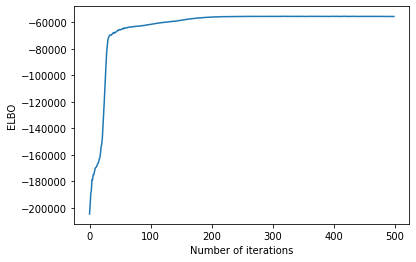

In [7]:
# Run options
LEARNING_RATE = 1.0e-1

# Run only for a single iteration for testing
NUM_EPOCHS = 500

#train_loader = setup_data_loader(batch_size=300)

# Model specifications
no_latent = 2
no_attributes = 28 * 28

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):

    loss = svi.step(data.data, no_attributes, no_latent)
    train_elbo.append(-loss)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()


### Learned parameters

In [8]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.numpy())

z_loc [[-1.1470091e+00 -1.3545760e+00]
 [-1.5703272e+00 -1.3735225e+00]
 [-1.6419924e+00 -1.6375301e+00]
 [-1.3434038e+00 -1.3377187e+00]
 [-1.3747662e+00 -1.3691884e+00]
 [-1.2631598e+00 -1.9123390e+00]
 [-1.5772175e+00 -2.3964462e+00]
 [-4.2693964e-01 -2.4567893e+00]
 [-1.5567222e+00 -1.4490285e+00]
 [-1.5823107e+00 -1.4258873e+00]
 [-1.2356250e+00 -1.4999740e+00]
 [-6.6030627e-01 -1.6086773e+00]
 [-1.5311646e+00 -1.5702312e+00]
 [-1.0022031e+00 -1.8806632e+00]
 [-1.6837983e+00 -1.0922565e+00]
 [-1.4556109e+00 -1.4722428e+00]
 [-3.6802810e-01 -1.6288786e+00]
 [-1.4184906e+00 -1.6702534e+00]
 [-6.7301029e-01 -1.4585053e+00]
 [-1.3204808e+00 -1.7652397e+00]
 [-3.0877241e-01 -3.2388549e+00]
 [-5.7241851e-01 -1.1432897e+00]
 [-1.4740058e+00 -1.4661173e+00]
 [-9.3468612e-01 -1.1907368e+00]
 [-9.1123110e-01 -1.4115499e+00]
 [-6.3377053e-01 -2.1918201e+00]
 [-1.0576537e+00 -1.7968425e+00]
 [-1.4227711e+00 -2.0142090e+00]
 [-1.0034443e+00 -1.9900936e+00]
 [-1.0846415e+00 -2.5538852e+00]
 [-1

### Distribution in latent space

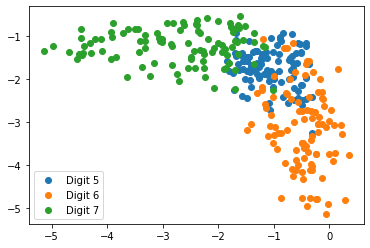

In [9]:
z_loc = pyro.param("z_loc").detach().numpy()
legends = ["Digit 5", "Digit 6", "Digit 7"]
for idx, i in enumerate([5,6,7]):
    plt.scatter(z_loc[data.targets.numpy()==i,0], z_loc[data.targets.numpy()==i,1], label=legends[idx])
plt.legend()
plt.show()